In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
from joblib import dump, load
from matplotlib import rc
%matplotlib inline
rc('text', usetex=False)
rc('mathtext', fontset='cm')
rc('xtick', labelsize=20)   
rc('xtick.major', size=7)  
rc('xtick.minor', size=4)
rc('xtick.major', width=2)
rc('xtick.minor', width=2)
rc('ytick.major', width=2)
rc('ytick.minor', width=2)
rc('ytick', labelsize=20)
rc('ytick.major', size=7)
rc('ytick.minor', size=4)
# rc('axes', labelsize=25) 
rc('axes', labelsize=25) 
rc('axes', linewidth=2) 
rc('font',family='sans serif')
rc('font', style='normal')
rc('font', weight='500')
rc('font', size='15')
rc('axes', labelweight='500')
rc('axes.spines', **{'right':True, 'top':True}) 
plt.rcParams['font.family'] = 'Arial'

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
class DeeperCNN(nn.Module):
    def __init__(self, num_classes=2, num_filters1=32, num_filters2=64, num_filters3=128,
                 kernel_size=5, dropout_rate=0.5):
        super(DeeperCNN, self).__init__()

        # Block 1
        self.block1 = nn.Sequential(
            nn.Conv2d(1, num_filters1, kernel_size=kernel_size, padding=2),  # Padding set to 2 for maintaining spatial size
            nn.BatchNorm2d(num_filters1),
            nn.ReLU(),
            nn.Conv2d(num_filters1, num_filters1, kernel_size=kernel_size, padding=2),
            nn.BatchNorm2d(num_filters1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Block 2
        self.block2 = nn.Sequential(
            nn.Conv2d(num_filters1, num_filters2, kernel_size=kernel_size, padding=2),
            nn.BatchNorm2d(num_filters2),
            nn.ReLU(),
            nn.Conv2d(num_filters2, num_filters2, kernel_size=kernel_size, padding=2),
            nn.BatchNorm2d(num_filters2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Block 3
        self.block3 = nn.Sequential(
            nn.Conv2d(num_filters2, num_filters3, kernel_size=kernel_size, padding=2),
            nn.BatchNorm2d(num_filters3),
            nn.ReLU(),
            nn.Conv2d(num_filters3, num_filters3, kernel_size=kernel_size, padding=2),
            nn.BatchNorm2d(num_filters3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Fully connected layers
        self.flatten = nn.Flatten()
        self.fc_layers = nn.Sequential(
            nn.Linear(512 * 16 * 16, 512),  # Corrected size
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.flatten(x)
        x = self.fc_layers(x)
        return x

In [3]:
import torch

# Initialize the model and load state dictionary
model = DeeperCNN()  # Ensure this matches your model definition
model.load_state_dict(torch.load("binary_model.pth"))
model.eval()  # Set the model to evaluation mode

DeeperCNN(
  (block1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): Sequential(
    (0): Conv2d(64, 12

# SHAP Analysis

In [4]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import shap

# Define transformation to apply to the images
transform = transforms.Compose([
    transforms.Grayscale(),  # Convert images to grayscale (if not already)
    transforms.Resize((258, 258)),  # Resize images to 258x258
    transforms.ToTensor()  # Convert images to PyTorch tensors
])

# Path to the directory containing the dataset
data_dir = "datasets/"

# Set a random seed for consistent splits
random_seed = 42
# random_seed = 10
torch.manual_seed(random_seed)

# Load the dataset from the directory
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Define dataset lengths for splitting
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Split the dataset into train, validation, and test sets
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Define data loaders for each split
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# Verify the splits
print(f"Total dataset size: {len(dataset)}")
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Total dataset size: 322
Train dataset size: 225
Validation dataset size: 64
Test dataset size: 33


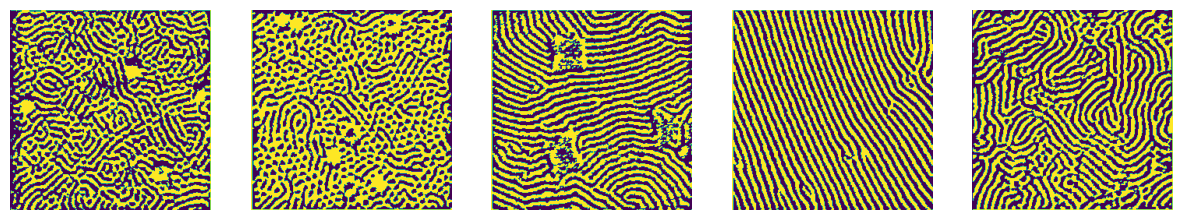

In [54]:
# since shuffle=True, this is a random sample of test data
batch = next(iter(test_loader))
images, _ = batch

background = images[:10]
test_images = images[10:15]

# Show the selected test images before applying SHAP analysis
fig, axes = plt.subplots(1, len(test_images), figsize=(15, 5))  # Adjust size as needed
for ax, img in zip(axes, test_images):
    ax.imshow(img.permute(1, 2, 0))  # Reorder dimensions to (H, W, C)
    ax.axis('off')
plt.show()

In [55]:
to_explain = torch.stack([test_images[i] for i in [3, 1]])  # Stack into a single tensor

output_path = 'figures/'
fig_title = '3clas_shap_block3.pdf'

class_map = {
    0: "Well-ordered",
    1: "Weakly-ordered"
}

e = shap.GradientExplainer((model, model.block3[3]), test_images)
shap_values, indexes = e.shap_values(to_explain, ranked_outputs=1, nsamples=20)
indexes = indexes.tolist()
# get the names for the classes
index_names = [[class_map[number] for number in sublist] for sublist in indexes]
index_names = np.array(index_names)
# plot the explanations
# shap_values = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
shap_values = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values]
shap_values = [s.transpose(2, 3, 1, 0) for s in shap_values]
to_explain = to_explain.numpy()
to_explain = [s.transpose(1, 2, 0) for s in to_explain]
to_explain = np.array(to_explain)

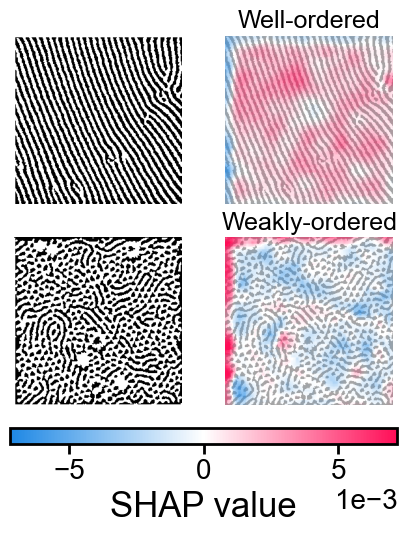

In [56]:
shap.image_plot(shap_values, to_explain, index_names, show=False)
# Save the plot
plt.savefig(output_path + fig_title, format='pdf')

In [57]:
to_explain = torch.stack([test_images[i] for i in [3, 1]])  # Stack into a single tensor
output_path = 'figures/'
fig_title = '3clas_shap_block2.pdf'

class_map = {
    0: "Well-ordered",
    1: "Weakly-ordered"
}

e = shap.GradientExplainer((model, model.block2[3]), test_images)
shap_values, indexes = e.shap_values(to_explain, ranked_outputs=1, nsamples=20)
indexes = indexes.tolist()
# get the names for the classes
index_names = [[class_map[number] for number in sublist] for sublist in indexes]
index_names = np.array(index_names)
# plot the explanations
# shap_values = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
shap_values = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values]
shap_values = [s.transpose(2, 3, 1, 0) for s in shap_values]
to_explain = to_explain.numpy()
to_explain = [s.transpose(1, 2, 0) for s in to_explain]
to_explain = np.array(to_explain)

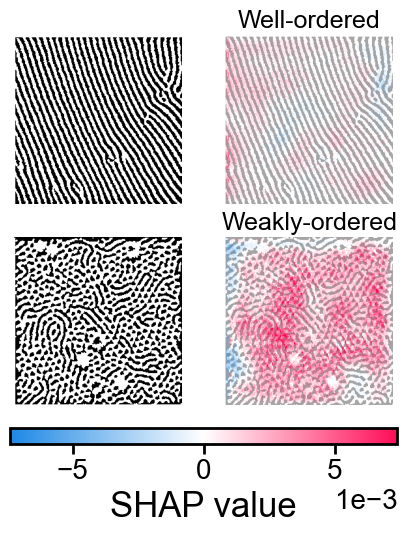

In [58]:
shap.image_plot(shap_values, to_explain, index_names, show=False)
# Save the plot
plt.savefig(output_path + fig_title, format='pdf')

In [59]:
to_explain = torch.stack([test_images[i] for i in [3, 1]])  # Stack into a single tensor
output_path = 'figures/'
fig_title = '3clas_shap_block1.pdf'

class_map = {
    0: "Well-ordered",
    1: "Weakly-ordered"
}

e = shap.GradientExplainer((model, model.block1[3]), test_images)
shap_values, indexes = e.shap_values(to_explain, ranked_outputs=1, nsamples=20)
indexes = indexes.tolist()
# get the names for the classes
index_names = [[class_map[number] for number in sublist] for sublist in indexes]
index_names = np.array(index_names)
# plot the explanations
# shap_values = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
shap_values = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values]
shap_values = [s.transpose(2, 3, 1, 0) for s in shap_values]
to_explain = to_explain.numpy()
to_explain = [s.transpose(1, 2, 0) for s in to_explain]
to_explain = np.array(to_explain)

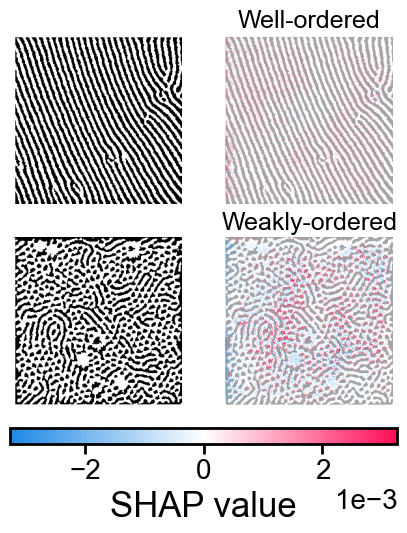

In [60]:
shap.image_plot(shap_values, to_explain, index_names, show=False)
# Save the plot
plt.savefig(output_path + fig_title, format='pdf')

# Prediction probabilities

In [15]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize

# Define class labels
class_labels = ['dots', 'lines', 'mixed']
cmap = plt.cm.bwr
norm = Normalize(0, 1)

# Define a function to visualize images with predictions and true labels
def visualize_predictions(model, data_loader, class_labels, num_images=5):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for i, (images, labels) in enumerate(data_loader):
            
            for j in range(len(images)):
                fig_title = f'probs/class_probs_{total}.png'
                image = images[j]
                label = labels[j]
                
                output = model(image.unsqueeze(0))  # Add extra dimension for batch
                _, predicted = torch.max(output, 1)
                
                image = image.numpy().transpose((1, 2, 0))
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                image = std * image + mean
                image = np.clip(image, 0, 1)
                prob = output.softmax(dim=1).squeeze().numpy()
                color = cmap(norm(prob))
                
                plt.figure(figsize=(8, 4))
                plt.subplot(1, 2, 1)
                plt.imshow(image)
                plt.title('Predicted: {}, Actual: {}'.format(class_labels[predicted.item()], 
                                                             class_labels[label.item()]))
                plt.axis('off')
                
                plt.subplot(1, 2, 2)
                plt.bar(range(len(class_labels)), output.softmax(dim=1).squeeze().numpy(), color=color)
                plt.xticks(range(len(class_labels)), class_labels, rotation=90)
                plt.ylabel('Probability')
                plt.title('Class Probabilities')
                plt.tight_layout()
                plt.ylim(0,1)
                plt.savefig(output_path + fig_title, dpi=1500, format='png')
                # plt.show()
                plt.close()
                
                # Update accuracy
                total += 1
                correct += (predicted == label).sum().item()
    
    accuracy = correct / total * 100
    print("Testing Accuracy: {:.2f}%".format(accuracy))

# Assuming you have imported necessary modules and defined train and test loaders
# Also, assuming class_labels is defined

# Visualize predictions for specific images from the test loader
visualize_predictions(model, test_loader, class_labels)


Testing Accuracy: 97.06%


In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# Define the figure title
fig_title = f'confusion_bin_image'

# Create the plasma colormap and its reverse
cmap = plt.cm.RdPu

# iterate over test data
for inputs, labels in test_loader:
        # print(labels)
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ['Well-\nordered', 'Weakly-\nordered']
# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)

In [12]:
from matplotlib import rc
%matplotlib inline
rc('text', usetex=False)
rc('mathtext', fontset='cm')
rc('xtick', labelsize=20)   
rc('xtick.major', size=7)  
rc('xtick.minor', size=4)
rc('xtick.major', width=2)
rc('xtick.minor', width=2)
rc('ytick.major', width=2)
rc('ytick.minor', width=2)
rc('ytick', labelsize=20)
rc('ytick.major', size=7)
rc('ytick.minor', size=4)
rc('axes', labelsize=25) 
rc('axes', linewidth=2) 
rc('font',family='sans serif')
rc('font', style='normal')
rc('font', weight='500')
rc('font', size='15')
rc('axes', labelweight='500')
rc('axes.spines', **{'right':True, 'top':True}) 
plt.rcParams['font.family'] = 'Arial'

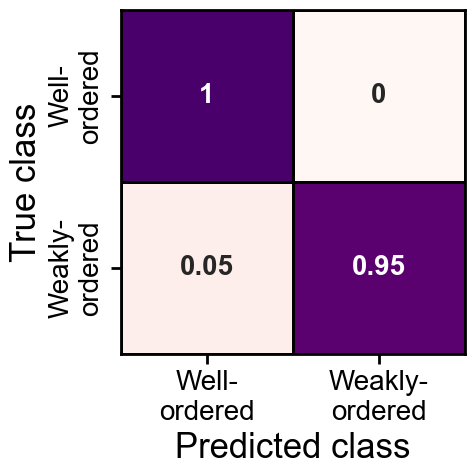

In [13]:
output_path = 'figures/'
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], 
                     index=[i for i in classes],
                     columns=[i for i in classes])

plt.figure(figsize=(5,5))
ax = sn.heatmap(df_cm, cmap=cmap, annot=True, annot_kws={'weight': 'bold', 'fontsize': 20}, 
                linewidths=2, linecolor='black', cbar=False)

# Center and space tick labels
ax.set_xticklabels(ax.get_xticklabels(), ha='center', va='center')
ax.set_yticklabels(ax.get_yticklabels(), ha='center', va='center')
ax.tick_params(axis='x', pad=25)
ax.tick_params(axis='y', pad=25)

# Axis labels
ax.set_xlabel('Predicted class')
ax.set_ylabel('True class')

# Outline for heatmap
for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_edgecolor('black')
    spine.set_linewidth(2)

plt.tight_layout()
plt.savefig(output_path + fig_title, format='pdf')